<a href="https://colab.research.google.com/github/unknown-aiby/PINNs/blob/main/stefans_1d1p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import timeit

class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name=None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name

    def sample(self, N):
        x = self.coords[0:1, :] + (self.coords[1:2, :] - self.coords[0:1, :]) * np.random.uniform(0, 1, size=(N, self.dim))
        y = self.func(x)
        return x, y

class DataSampler:
    # Initialize the class
    def __init__(self, X, Y, name = None):
        self.X = X
        self.Y = Y
        self.N = self.X.shape[0]

    def sample(self, batch_size):
        idx = np.random.choice(self.N, batch_size, replace=True)
        X_batch = self.X[idx, :]
        Y_batch = self.Y[idx, :]
        return X_batch, Y_batch

class Stefan1D_direct:
    def __init__(self, layers_u, layers_s, ics_sampler, Ncs_sampler, res_sampler):
        # Normalization constants
        X, _ = res_sampler.sample(np.int32(1e5))
        self.mu_X, self.sigma_X = X.mean(0), X.std(0)
        self.mu_x, self.sigma_x = self.mu_X[0], self.sigma_X[0]
        self.mu_t, self.sigma_t = self.mu_X[1], self.sigma_X[1]

        # Samplers
        self.ics_sampler = ics_sampler
        self.Ncs_sampler = Ncs_sampler
        self.res_sampler = res_sampler

        # Initialize network weights and biases
        self.layers_u = layers_u
        self.weights_u, self.biases_u = self.initialize_NN(layers_u)
        
        self.layers_s = layers_s
        self.weights_s, self.biases_s = self.initialize_NN(layers_s)

        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

        # Define placeholders and computational graph
        self.x_u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.s_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x_0_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_0_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_0_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x_Nc_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_Nc_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_Nc_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.s_Nc_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_r_tf = tf.placeholder(tf.float32, shape=(None, 1))

        # Evaluate predictions
        self.s_pred = self.net_s(self.t_u_tf)
        self.u_pred = self.net_u(self.x_u_tf, self.t_u_tf)

        self.u_0_pred = self.net_u(self.x_0_tf, self.t_0_tf)
        self.u_Sbc_pred = self.net_u((self.s_pred - self.mu_x) / self.sigma_x, self.t_u_tf)
        self.s_0_pred = self.net_s(self.t_0_tf)
        self.u_Nc_pred = self.net_u_x(self.x_Nc_tf, self.t_Nc_tf)

        self.r_u_pred = self.net_r_u(self.x_r_tf, self.t_r_tf)
        self.r_Nc_pred = self.net_r_Nc(self.t_Nc_tf)

        # Boundary loss and Neumann loss
        self.loss_u_0 = tf.reduce_mean(tf.square(self.u_0_pred - self.u_0_tf))
        self.loss_Sbc = tf.reduce_mean(tf.square(self.u_Sbc_pred))
        self.loss_s_0 = tf.reduce_mean(tf.square(self.s_0_pred - (2.0 - np.sqrt(3))))
        self.loss_uNc = tf.reduce_mean(tf.square(self.u_Nc_pred - 2.0))

        # Residual loss
        self.loss_res = tf.reduce_mean(tf.square(self.r_u_pred))
        self.loss_SNc = tf.reduce_mean(tf.square(self.r_Nc_pred - self.s_Nc_tf))

        # Total loss
        self.loss_ics = self.loss_s_0 + self.loss_u_0
        self.loss_bcs = self.loss_Sbc + self.loss_SNc + self.loss_uNc
        self.loss = self.loss_bcs + self.loss_ics + self.loss_res

        # Define optimizer with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,
                                                        1000, 0.9, staircase=False)
        # Passing global_step to minimize() will increment it at each step.
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)

        self.loss_bcs_log = []
        self.loss_ics_log = []
        self.loss_res_log = []
        self.saver = tf.train.Saver()

        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

    # Xavier initialization
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
        return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,
                           dtype=tf.float32)

    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    # Evaluates the forward pass
    def forward_pass_u(self, H):
        num_layers = len(self.layers_u)
        for l in range(0, num_layers - 2):
            W = self.weights_u[l]
            b = self.biases_u[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = self.weights_u[-1]
        b = self.biases_u[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H

    def forward_pass_s(self, H):
        num_layers = len(self.layers_s)
        for l in range(0, num_layers - 2):
            W = self.weights_s[l]
            b = self.biases_s[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = self.weights_s[-1]
        b = self.biases_s[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H

    def net_u(self, x, t):
        u = self.forward_pass_u(tf.concat([x, t], 1))
        return u

    def net_s(self, t):
        s = self.forward_pass_s(t)
        return s

    def net_u_x(self, x, t):
        u = self.net_u(x, t)
        u_x = tf.gradients(u, x)[0] / self.sigma_x
        return u_x

    # Forward pass for residual
    def net_r_u(self, x, t):
        u = self.net_u(x, t)
        u_t = tf.gradients(u, t)[0] / self.sigma_t
        u_x = tf.gradients(u, x)[0] / self.sigma_x
        u_xx = tf.gradients(u_x, x)[0] / self.sigma_x
        residual = u_t - u_xx
        return residual

    def net_r_Nc(self, t):
        s = self.net_s(t)

        # Normalize s
        s = (s - self.mu_x) / self.sigma_x

        u_x = self.net_u_x(s, t)
        residual = u_x
        return residual

    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        X = (X - self.mu_X) / self.sigma_X
        return X, Y

    def train(self, nIter=10000, batch_size=128):
        start_time = timeit.default_timer()
        for it in range(nIter):
            # Fetch boundary and Neumann mini-batches
            X_ics_batch, u_ics_batch = self.fetch_minibatch(self.ics_sampler, batch_size)
            X_Ncs_batch, u_Ncs_batch = self.fetch_minibatch(self.Ncs_sampler, batch_size)
   
            # Fetch residual mini-batch
            X_res_batch, _ = self.fetch_minibatch(self.res_sampler, batch_size)

            # Define a dictionary for associating placeholders with data
            tf_dict = {self.x_u_tf: X_res_batch[:, 0:1], self.t_u_tf: X_res_batch[:, 1:2],
                       self.x_0_tf: X_ics_batch[:, 0:1], self.t_0_tf: X_ics_batch[:, 1:2],
                       self.u_0_tf: u_ics_batch,
                       self.x_Nc_tf: X_Ncs_batch[:, 0:1], self.t_Nc_tf: X_Ncs_batch[:, 1:2],
                       self.s_Nc_tf: u_Ncs_batch,
                       self.x_r_tf: X_res_batch[:, 0:1], self.t_r_tf: X_res_batch[:, 1:2]}

            # Run the Tensorflow session to minimize the loss
            self.sess.run(self.train_op, tf_dict)

            # Print
            if it % 10 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_ics_value, loss_bcs_value, loss_res_value = self.sess.run([self.loss_ics, self.loss_bcs, self.loss_res], tf_dict)
                self.loss_ics_log.append(loss_ics_value)
                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_res_log.append(loss_res_value)

                print('It: %d, Loss: %.3e, Loss_ics: %.3e, Loss_bcs: %.3e, Loss_res: %.3e, Time: %.2f' %
                      (it, loss_value, loss_ics_value, loss_bcs_value, loss_res_value, elapsed))
                start_time = timeit.default_timer()

    # Predictions for u
    def predict_u(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.x_u_tf: X_star[:, 0:1], self.t_u_tf: X_star[:, 1:2]}
        u_star = self.sess.run(self.u_pred, tf_dict)
        return u_star

    # Predictions for s
    def predict_s(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.t_u_tf: X_star[:, 1:2]}
        s_star = self.sess.run(self.s_pred, tf_dict)
        return s_star
    
    def predict_r_u(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.t_u_tf: X_star[:, 1:2]}
        r_u_star = self.sess.run(self.r_u_pred, tf_dict)
        return r_u_star





Instructions for updating:
non-resource variables are not supported in the long term


Device mapping: no known devices.
It: 0, Loss: 2.200e+00, Loss_ics: 5.036e-02, Loss_bcs: 1.409e+00, Loss_res: 7.415e-01, Time: 0.94
It: 10, Loss: 6.028e-01, Loss_ics: 1.282e-01, Loss_bcs: 1.932e-01, Loss_res: 2.815e-01, Time: 0.10
It: 20, Loss: 3.214e-01, Loss_ics: 5.779e-03, Loss_bcs: 1.950e-01, Loss_res: 1.206e-01, Time: 0.11
It: 30, Loss: 2.604e-01, Loss_ics: 4.013e-03, Loss_bcs: 2.196e-01, Loss_res: 3.682e-02, Time: 0.12
It: 40, Loss: 2.317e-01, Loss_ics: 3.814e-03, Loss_bcs: 1.737e-01, Loss_res: 5.424e-02, Time: 0.11
It: 50, Loss: 2.212e-01, Loss_ics: 2.604e-03, Loss_bcs: 1.780e-01, Loss_res: 4.056e-02, Time: 0.11
It: 60, Loss: 1.985e-01, Loss_ics: 2.132e-03, Loss_bcs: 1.620e-01, Loss_res: 3.437e-02, Time: 0.13
It: 70, Loss: 1.922e-01, Loss_ics: 1.534e-03, Loss_bcs: 1.644e-01, Loss_res: 2.622e-02, Time: 0.13
It: 80, Loss: 1.877e-01, Loss_ics: 8.875e-04, Loss_bcs: 1.606e-01, Loss_res: 2.621e-02, Time: 0.18
It: 90, Loss: 1.758e-01, Loss_ics: 1.249e-03, Loss_bcs: 1.538e-01, Loss_res:

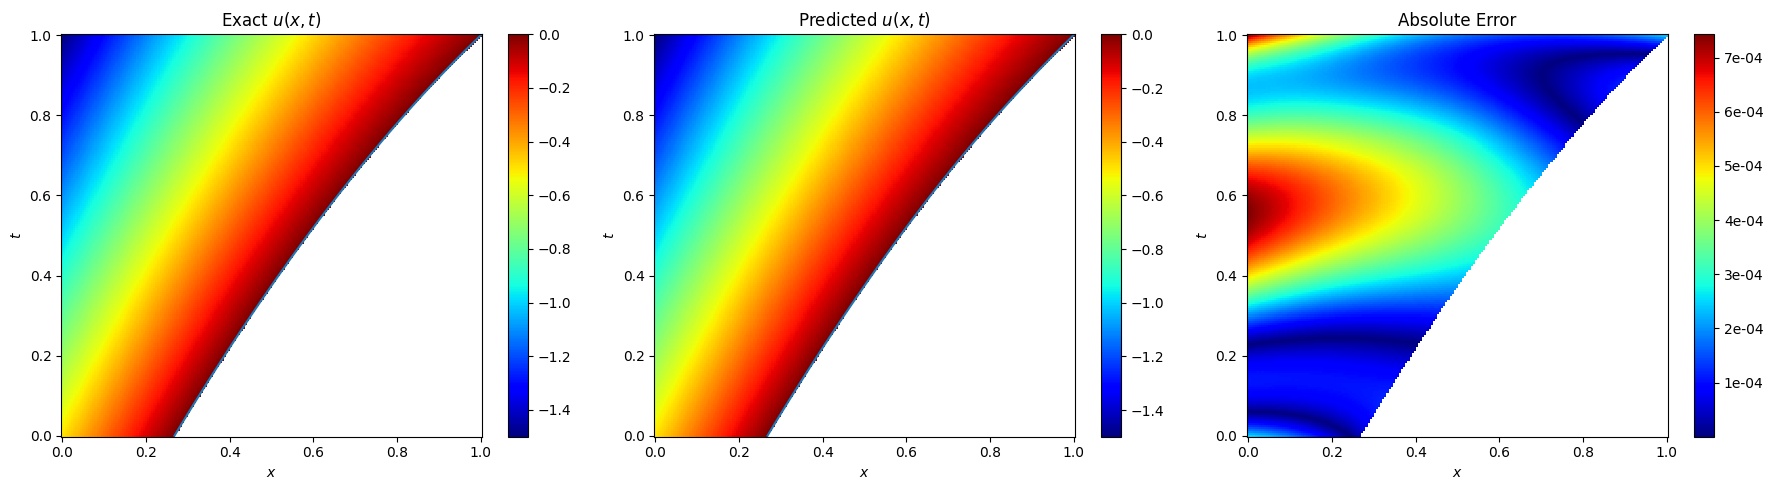

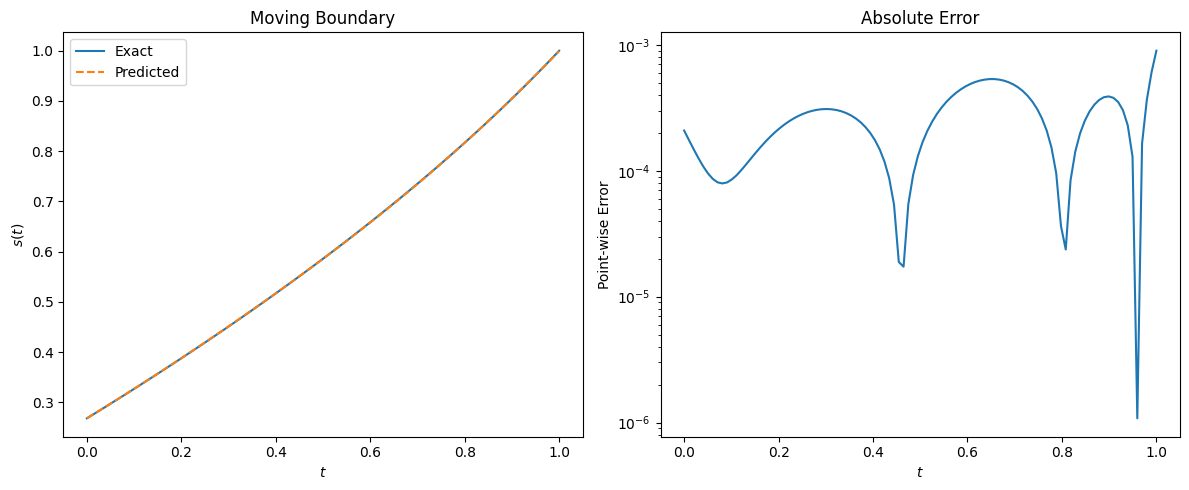

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Feb 25 20:27:53 2020

@author: sifan
"""

#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter
from scipy.interpolate import griddata
import seaborn as sns
#from Stefan_models_tf import Sampler, DataSampler, Stefan1D_direct
import pandas as pd
import os


if __name__ == '__main__':

    # Exact Solution
    def u(z):
        # x = (x, t)
        x = z[:, 0: 1]
        t = z[:, 1: 2]
        u = - 0.5 * x**2  + 2 * x - t - 0.5
        return u

    # Exact free boundary
    def s(x):
        t = x[:, 1: 2]
        s = 2 - np.sqrt(3 - 2 * t)
        return s

    def h(x):
        # du / dx (s(t), t) = h(t)   Stefan Neumann Condition
        t = x[:, 1: 2]
        h = np.sqrt(3 - 2 * t)
        return h

    def g(x):
        # - du /dx (0, t) = g(t)  Neumann Condition
        N = x.shape[0]
        return 2.0 * np.ones((N,1))

    def u_0(x):
        #  Initial Condition
        x = x[:, 0: 1]
        return - 0.5 * x**2 + 2 * x - 0.5

    def S_0(x):
        # Initial Condtion for S0
        S_0 = 2 - np.sqrt(3)
        N = x.shape[0]
        return S_0 * np.ones((N, 1))

    # Domain boundaries
    ic_coords = np.array([[0.0, 0.0],
                          [1.0, 0.0]])
    Nc_coords = np.array([[0.0, 0.0],
                          [0.0, 1.0]])
    dom_coords = np.array([[0.0, 0.0],
                           [1.0, 1.0]])

    # Create boundary conditions samplers
    ics_sampler = Sampler(2, ic_coords, lambda x: u_0(x), name='Initial Condition')
    Ncs_sampler = Sampler(2, Nc_coords, lambda x: h(x), name='Stefan Neumann Boundary Condition')  # because t_u_tf

    # Create residual sampler
    res_sampler = Sampler(2, dom_coords, lambda x: u(x), name='Forcing')

    # Define model
    layers_u = [2, 100, 100, 100, 1]
    layers_s = [1, 100, 100, 100, 1]  # or we can map s to (t, s(t))
    model = Stefan1D_direct(layers_u, layers_s, ics_sampler, Ncs_sampler, res_sampler)

    model.train(nIter=40000, batch_size=128)
    
    ### Save Model ###
    ####################
    # save path
    # Test data
    nn = 200
    x = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
    t = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
    X, T = np.meshgrid(x, t)
    X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    
    # Exact solutions
    u_star = u(X_star)
    s_star = s(X_star)
    
    # Predictions
    u_pred = model.predict_u(X_star)
    s_pred = model.predict_s(X_star)
    
    # Errors
    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    error_s = np.linalg.norm(s_star - s_pred, 2) / np.linalg.norm(s_star, 2)

    print('Relative L2 error_u: {:.2e}'.format(error_u))
    print('Relative L2 error_s: {:.2e}'.format(error_s))
      

    U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')
    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
    
    for i in range(nn):
        for j in range(nn):
            X_ij = np.array([X[i,j], T[i,j]]).reshape(1,2)
            u_ij = u(X_ij)
            s_ij = s(X_ij)
            if X[i,j] > s_ij:
                U_star[i,j] = np.nan
                U_pred[i,j] = np.nan
                                
    t = np.linspace(0,1, 100)[:, None]
    x = np.zeros_like(t)
    x_star = np.concatenate((x,t), axis=1)
    
    s_star = s(x_star)
    s_pred = model.predict_s(x_star)
    error_s = np.abs(s_star - s_pred)
                
    fig_1 = plt.figure(1, figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.plot(s_star, t)
    plt.pcolor(X, T, U_star, cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x$')
    plt.ylabel(r'$t$')
    plt.title('Exact $u(x,t)$')
    
    plt.subplot(1, 3, 2)
    plt.pcolor(X, T, U_pred, cmap='jet')
    plt.plot(s_pred, t)
    plt.colorbar()
    plt.xlabel(r'$x$')
    plt.ylabel(r'$t$')
    plt.title('Predicted $u(x,t)$')

    plt.subplot(1, 3, 3)
    plt.pcolor(X, T, np.abs(U_star - U_pred), cmap='jet')
    plt.colorbar(format='%.0e')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$t$')
    plt.title('Absolute Error')
    
    plt.tight_layout()
    plt.show()
    
    fig_2 = plt.figure(2, figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(t, s_star, label='Exact')
    plt.plot(t, s_pred, '--', label='Predicted')
    plt.xlabel(r'$t$')
    plt.ylabel(r'$s(t)$')
    plt.title('Moving Boundary')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(t, error_s)
    plt.xlabel(r'$t$')
    plt.ylabel(r'Point-wise Error')
    plt.title('Absolute Error')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

    

    
